# Distribution of feature - regional deviation

In [1]:
import pandas as pd
from scipy.stats import ks_2samp
from tqdm import tqdm

# Load training data
train_data = pd.read_csv('train_data.csv')

# Define features and target
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'amplitude_rcc', 'phase_rcc', 'offset_rcc', 'elevation', 'aspect']
X_train = train_data[features]
y_train = train_data['phen']

# Function to calculate deviation score for each feature in each region
def calculate_deviation_scores(data, features):
    regions = data['greco_region'].unique()
    deviation_scores = pd.DataFrame(index=regions, columns=features)
    
    for feature in tqdm(features):
        overall_distribution = data[feature]
        
        for region in regions:
            region_data = data[data['greco_region'] == region][feature]
            ks_stat, _ = ks_2samp(overall_distribution, region_data)
            deviation_scores.loc[region, feature] = ks_stat
    
    return deviation_scores

# Calculate deviation scores
deviation_scores = calculate_deviation_scores(train_data, features)

# Identify the region with the highest deviation for each feature
#chang dtypes to float
deviation_scores = deviation_scores.astype(float)
most_deviated_region_per_feature = deviation_scores.idxmax()

print(f'Most deviated region per feature:\n{most_deviated_region_per_feature}')


100%|██████████| 11/11 [00:43<00:00,  3.92s/it]

Most deviated region per feature:
amplitude_red       Côtes_et_plateaux_de_la_Manche
phase_red                          Ardenne_primaire
offset_red                  Premier_plateau_du_Jura
amplitude_crswir                   Ardenne_primaire
phase_crswir        Côtes_et_plateaux_de_la_Manche
offset_crswir               Premier_plateau_du_Jura
amplitude_rcc                      Ardenne_primaire
phase_rcc                          Préalpes_du_Nord
offset_rcc                  Premier_plateau_du_Jura
elevation           Côtes_et_plateaux_de_la_Manche
aspect                             Préalpes_du_Nord
dtype: object


# Distribution of feature and deciduous/evergreen proportion

100%|██████████| 11/11 [01:43<00:00,  9.40s/it]


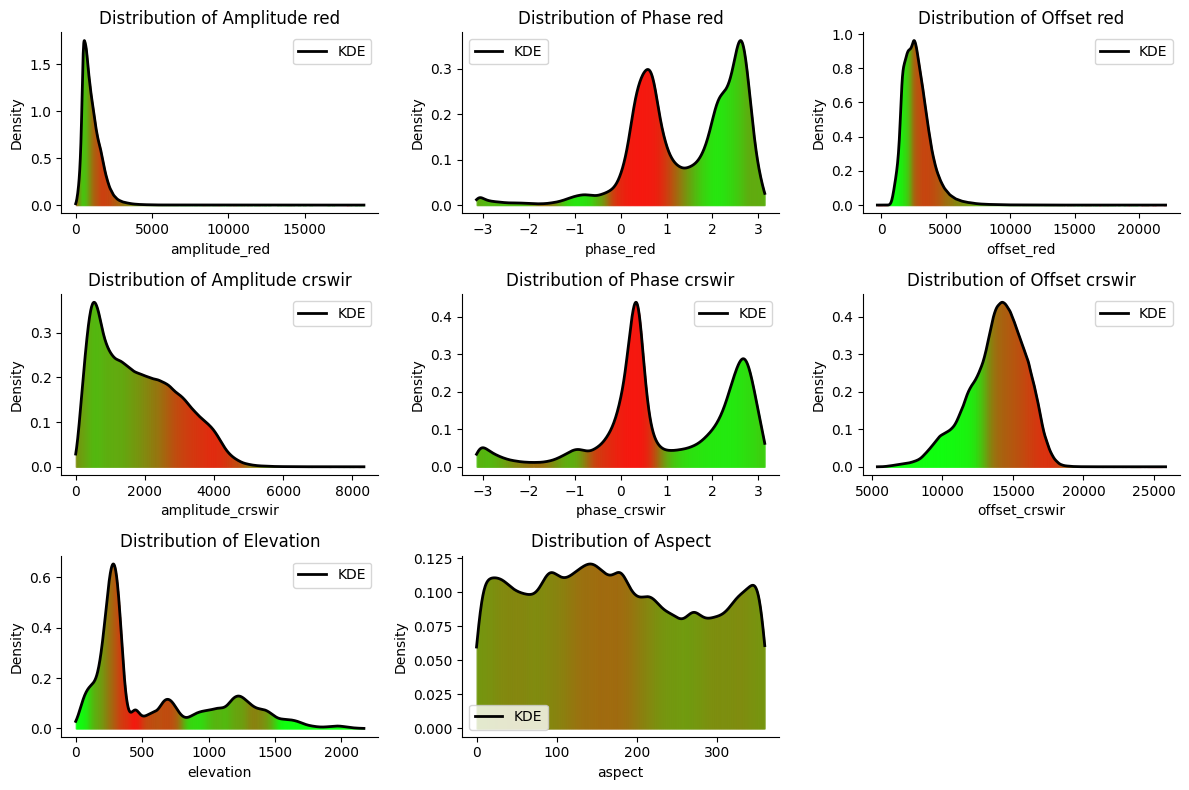

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np


# Function to compute KDE and color the area under the curve
def plot_kde_with_colored_area(data, feature, ax):
    # Data for deciduous and evergreen
    data_deciduous = data[data['phen'] == 1][feature]
    data_evergreen = data[data['phen'] == 2][feature]

    # Calculate KDE
    kde_deciduous = gaussian_kde(data_deciduous)
    kde_evergreen = gaussian_kde(data_evergreen)
    
    # X values for KDE
    x_vals = np.linspace(data[feature].min(), data[feature].max(), 1000)
    kde_vals_deciduous = kde_deciduous(x_vals)
    kde_vals_evergreen = kde_evergreen(x_vals)

    # Calculate proportions
    total_kde_vals = kde_vals_deciduous + kde_vals_evergreen
    prop_deciduous = kde_vals_deciduous / total_kde_vals
    prop_evergreen = kde_vals_evergreen / total_kde_vals

    # Normalize to get percentages
    total_kde_vals_percent = (total_kde_vals / total_kde_vals.sum()) * 100

    # Plot KDE
    sns.lineplot(x=x_vals, y=total_kde_vals_percent, ax=ax, color='black', label='KDE', linewidth=2)

    # Color the area under the curve
    for i in range(len(x_vals) - 1):
        ax.fill_between(x_vals[i:i+2], 0, total_kde_vals_percent[i:i+2], color=(prop_deciduous[i], prop_evergreen[i], 0, 0.3))

    feature_name = feature.replace('_', ' ').capitalize()
    ax.set_title(f'Distribution of {feature_name}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()

# Plot distributions for overall data using KDE with colored areas
fig = plt.figure(figsize=(12, 8))
idx = 0
for feature in tqdm(features):
    if 'rcc' in feature:
        continue

    ax = plt.subplot(3, 3, idx + 1)
    plot_kde_with_colored_area(train_data, feature, ax)
    idx += 1

plt.tight_layout()
plt.show()
fig.savefig('images/kde_colored_area.png', dpi=300, bbox_inches='tight')


# Correlation between features

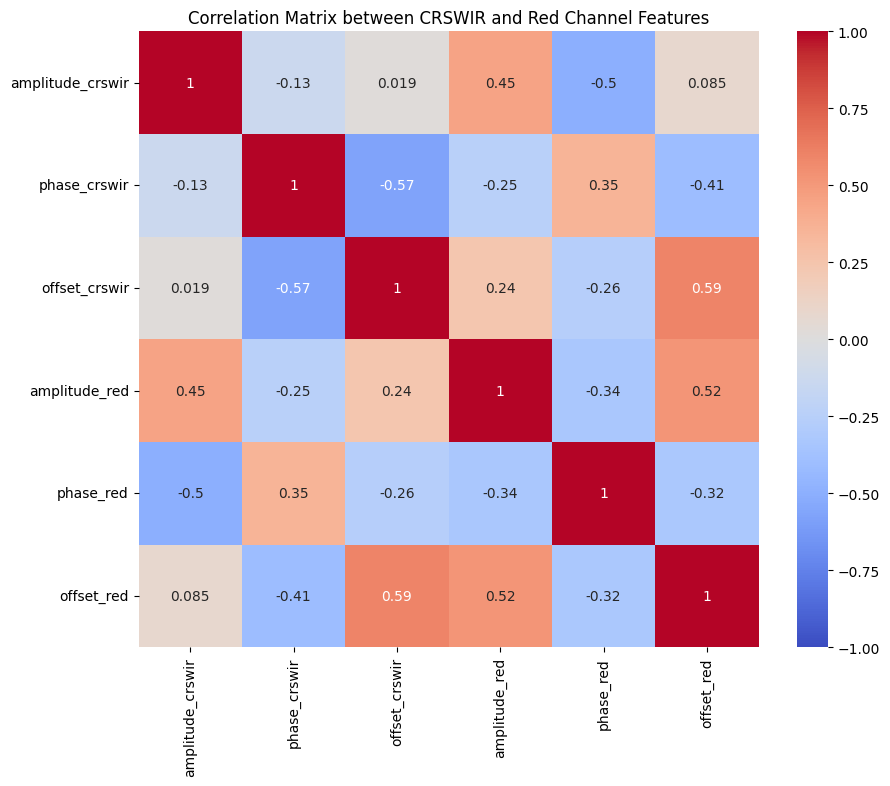

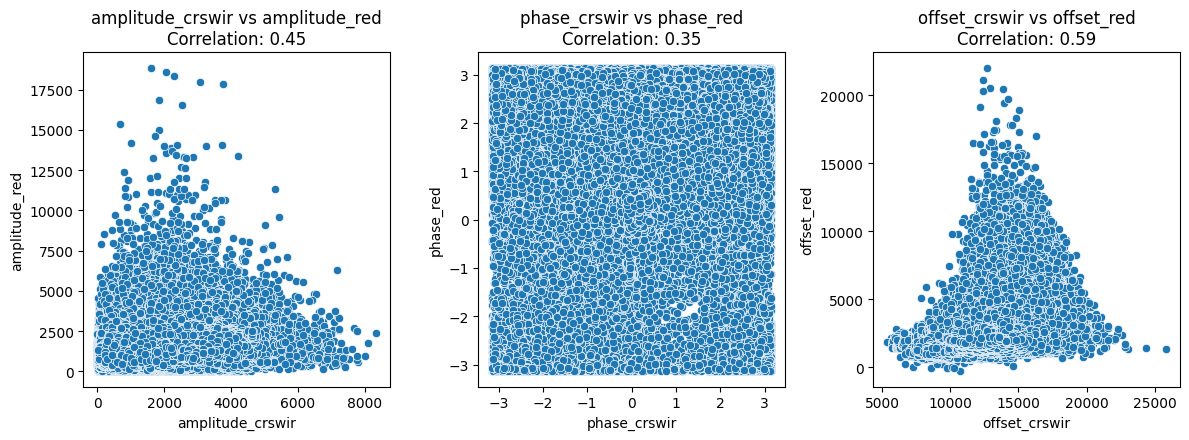

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load training data
train_data = pd.read_csv('train_data.csv')

# Define feature pairs
feature_pairs = [
    ('amplitude_crswir', 'amplitude_red'),
    ('phase_crswir', 'phase_red'),
    ('offset_crswir', 'offset_red')
]

# Compute correlation matrix
correlation_data = train_data[[pair[0] for pair in feature_pairs] + [pair[1] for pair in feature_pairs]]
correlation_matrix = correlation_data.corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix between CRSWIR and Red Channel Features')
plt.show()

# Scatter plots with correlation coefficients
plt.figure(figsize=(12, 8))
for i, (crswir_feature, red_feature) in enumerate(feature_pairs):
    plt.subplot(2, 3, i + 1)
    sns.scatterplot(x=train_data[crswir_feature], y=train_data[red_feature])
    r = train_data[crswir_feature].corr(train_data[red_feature])
    plt.title(f'{crswir_feature} vs {red_feature}\nCorrelation: {r:.2f}')
    plt.xlabel(crswir_feature)
    plt.ylabel(red_feature)

plt.tight_layout()
plt.show()


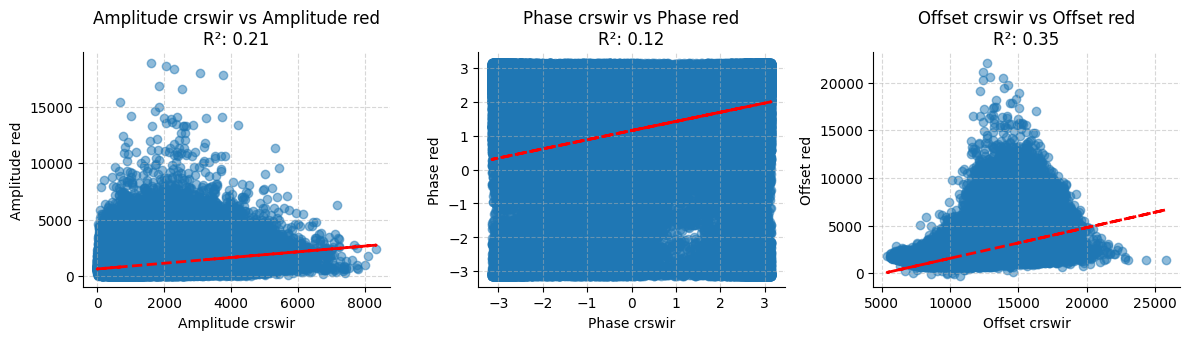

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Function to plot linear regression
def plot_linear_regression(data, x_feature, y_feature, ax):
    X = data[x_feature].values.reshape(-1, 1)
    y = data[y_feature].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    
    ax.scatter(X, y, alpha=0.5)
    ax.plot(X, y_pred, color='red', linewidth=2, linestyle='--')
    r2 = r2_score(y, y_pred)
    x_feature = x_feature.replace('_', ' ').capitalize()
    y_feature = y_feature.replace('_', ' ').capitalize()
    ax.set_title(f'{x_feature} vs {y_feature}\nR²: {r2:.2f}')
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, linestyle='--', alpha=0.5)

# Plot linear regression
fig = plt.figure(figsize=(12, 6))
for i, (crswir_feature, red_feature) in enumerate(feature_pairs):
    ax = plt.subplot(2, 3, i + 1)
    plot_linear_regression(train_data, crswir_feature, red_feature, ax)

plt.tight_layout()
plt.show()
fig.savefig('images/linear_regression.png', dpi=300, bbox_inches='tight')


# LDA analysis 

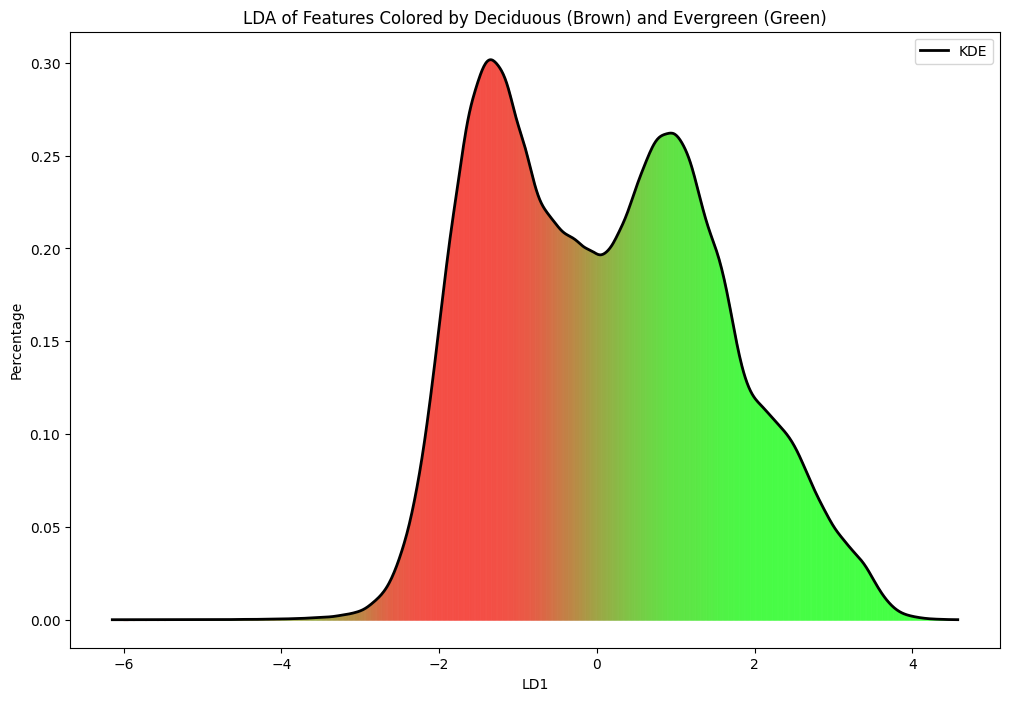

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Load data
train_data = pd.read_csv('train_data.csv')
features = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'elevation', 'aspect']
X = train_data[features]
y = train_data['phen']

# Apply LDA
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X, y)

# Create a DataFrame with LDA component and class labels
lda_df = pd.DataFrame(data=X_lda, columns=['LD1'])
lda_df['phen'] = y

# Function to compute KDE and color the area under the curve
def plot_kde_with_colored_area(data, feature, ax):
    # Data for deciduous and evergreen
    data_deciduous = data[data['phen'] == 1][feature]
    data_evergreen = data[data['phen'] == 2][feature]

    # Calculate KDE
    kde_deciduous = gaussian_kde(data_deciduous)
    kde_evergreen = gaussian_kde(data_evergreen)
    
    # X values for KDE
    x_vals = np.linspace(data[feature].min(), data[feature].max(), 1000)
    kde_vals_deciduous = kde_deciduous(x_vals)
    kde_vals_evergreen = kde_evergreen(x_vals)

    # Calculate proportions
    total_kde_vals = kde_vals_deciduous + kde_vals_evergreen
    prop_deciduous = kde_vals_deciduous / total_kde_vals
    prop_evergreen = kde_vals_evergreen / total_kde_vals

    # Normalize to get percentages
    total_kde_vals_percent = (total_kde_vals / total_kde_vals.sum()) * 100

    # Plot KDE
    sns.lineplot(x=x_vals, y=total_kde_vals_percent, ax=ax, color='black', label='KDE', linewidth=2)

    # Color the area under the curve
    for i in range(len(x_vals) - 1):
        ax.fill_between(x_vals[i:i+2], 0, total_kde_vals_percent[i:i+2], 
                        color=(prop_deciduous[i], prop_evergreen[i], 0, 0.3))

    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Percentage')
    ax.legend()

# Plot the LDA component
plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 1, 1)
plot_kde_with_colored_area(lda_df, 'LD1', ax)
plt.title('LDA of Features Colored by Deciduous (Brown) and Evergreen (Green)')
plt.show()


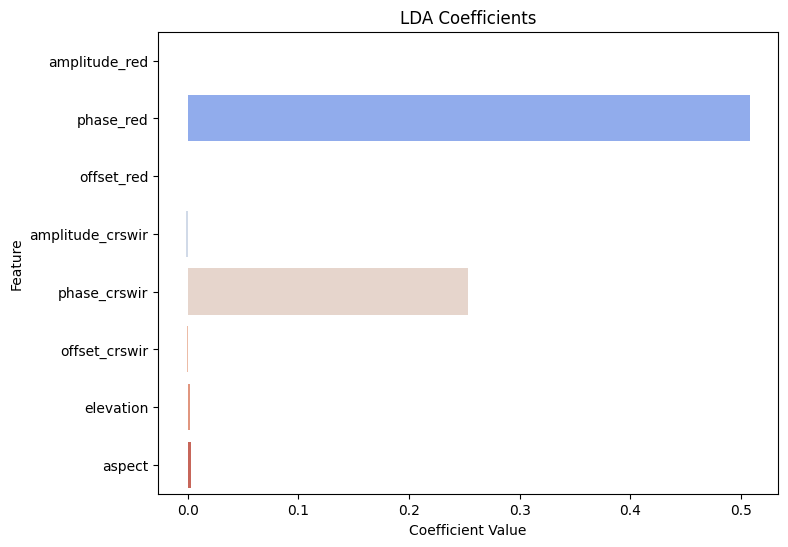

In [7]:
lda.coef_

#plot lda coef importance
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names
feature_names = ['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir', 'phase_crswir', 'offset_crswir', 'elevation', 'aspect']

# Plot LDA coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x=lda.coef_[0], y=feature_names, palette='coolwarm')
plt.title('LDA Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

In [6]:
lda.feature_names_in_

array(['amplitude_red', 'phase_red', 'offset_red', 'amplitude_crswir',
       'phase_crswir', 'offset_crswir', 'elevation', 'aspect'],
      dtype=object)